In [7]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# rsp imports
from lsst.summit.utils.utils import detectSources
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.ip.isr.isrTask import IsrTask

In [45]:
class sttrdImg():
    """Analysis class for stuttered images taken at AuxTel."""
    def __init__(self, expId, shift=50):
        obsdate = int(str(expId)[:8])
        seq_num = int(str(expId)[8:])
        
        self.dataId = {'day_obs': obsdate, 'seq_num': seq_num, 'detector': 0}
        self.exp = self.runIsr()
        
        self.allSources = self.runDetect()
        
        self.shift = 50
        self.pixels = self.exp.image.array.shape
        self.mid = int(self.pixels[0] / 2)
        
        self.cat1, self.cat2 = self.getSpotCat()
        
    def runIsr(self):
        isrConfig = IsrTask.ConfigClass()
        isrConfig.doLinearize = False
        isrConfig.doBias = True
        isrConfig.doFlat = False
        isrConfig.doDark = False
        isrConfig.doFringe = False
        isrConfig.doDefect = True
        isrConfig.doWrite = False
        isrConfig.doSaturation = False
        isrConfig.doNanInterpolation = False
        isrConfig.doNanMasking = False
        isrConfig.doSaturation = False
        isrConfig.doSaturationInterpolation = False
        isrConfig.doWidenSaturationTrails = False
        
        isrTask = IsrTask(config=isrConfig)

        raw = butler.get('raw', self.dataId)
        bias = butler.get('bias', self.dataId)
        defects = butler.get('defects', self.dataId)
        exp = isrTask.run(raw, bias=bias, defects=defects).exposure
        return exp
    
    def runDetect(self):
        sources = detectSources(self.exp.image.array, self.exp.variance.array)
        return sources
    
    def getSpotCat(self):
        fluxes = np.array([src.flux for src in self.allSources])
        x = np.array([src.x for src in self.allSources])

        # find the series of spots for 2 brightest sources
        max_1 = np.argmax(fluxes)
        x_max = x[max_1]
        spot_1 = np.where(abs(x - x_max) < 10)
        
        flux_max = fluxes[spot_1]
        fluxes[spot_1] = 0
        max_2 = np.argmax(fluxes)
        fluxes[spot_1] = flux_max

        x_max = x[max_2]
        spot_2 = np.where(abs(x - x_max) < 10)
        
        cat1 = self.makeSingleCat(spot_1)
        cat2 = self.makeSingleCat(spot_2)
        
        return cat1, cat2
        
    def makeSingleCat(self, spot):
        xs = np.array([src.x for src in self.allSources])[spot]
        fs = np.array([src.flux for src in self.allSources])[spot]
        ys = np.array([src.y for src in self.allSources])[spot]
        
        # sort the spot series
        ys = np.sort(ys)
        index = np.linspace(0,len(ys)-1, len(ys))
        
        # is it in top or bottom half of the image?
        i = np.searchsorted(ys, self.mid)
        if i == len(ys):
            # bottom half, so need to flip order of spots to match direction of time
            ys = ys[::-1]
            xs = xs[::-1]
            fs = fs[::-1]
        elif i != 0:
            # if i==0, top half -> no action required
            # else, problem: not all the spot series is in the same half of the image!
            raise ValueError('Spot series crossed image midline! Check selection.')
        
        return pd.DataFrame(data=np.array([xs,ys,fs]).T, columns=['x','y','flux'])
    
    def display(self, ax, sources=False):
        ax.imshow(np.arcsinh(10*self.exp.image.array)/10, cmap="magma", origin="lower")
        if sources:
            [ax.plot(src.x, src.y, 'wx') for src in self.allSources]
            ax.plot(self.cat1['x'], self.cat1['y'], 'rx')
            ax.plot(self.cat2['x'], self.cat2['y'], 'bx')

In [46]:
butler = butlerUtils.makeDefaultLatissButler(embargo=True)

# extraWhere = "exposure.observation_type='stuttered'"
# seqNums = butlerUtils.getSeqNumsForDayObs(butler, 20221012, extraWhere=extraWhere)
# seqNums

expid = 2022101200478
img = sttrdImg(expid)

/home/c/chebert/repos/summit_utils/python/lsst/summit/utils/utils.py:654: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.nanmedian(np.sqrt(variance))


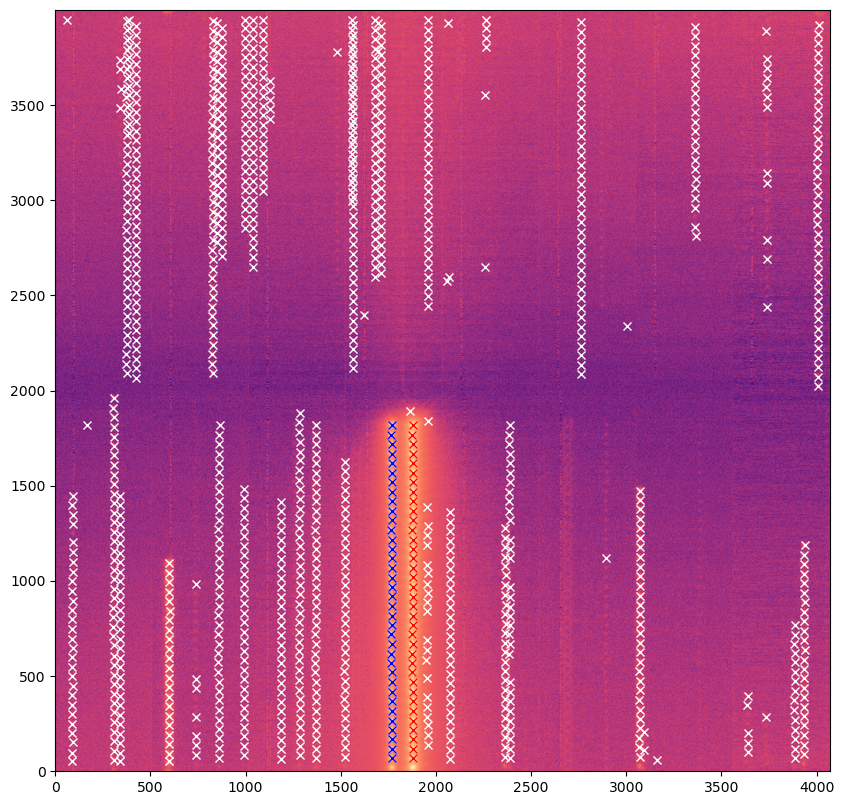

In [47]:
f, ax = plt.subplots(1,1, figsize=(10,10))
img.display(ax, sources=True)
plt.show()

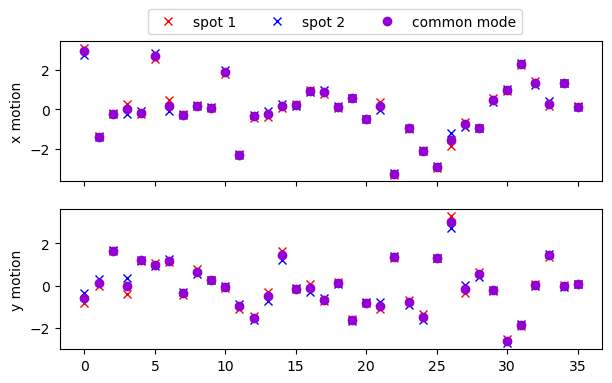

In [88]:
f, a = plt.subplots(2,1, figsize=(7,4), sharex=True)

for cat, color, label in zip([img.cat1, img.cat2], ['r', 'b'], ['spot 1', 'spot 2']):
    y_to_plot = cat['y'] + cat.index*img.shift
    a[0].plot(cat.index, cat['x'] - cat['x'].mean(), 'x', color=color, label=label)
    a[1].plot(cat.index, y_to_plot - y_to_plot.mean(), 'x', color=color)

common_x = (img.cat1['x'] + img.cat2['x']) / 2
common_y = (img.cat1['y'] + img.cat2['y']) / 2  + img.cat1.index*img.shift

a[0].plot(img.cat1.index, common_x - common_x.mean(), 'o', color='darkviolet', label='common mode')
a[1].plot(img.cat1.index, common_y - common_y.mean(), 'o', color='darkviolet')

a[0].legend(ncol=3, bbox_to_anchor=(0.15,1))
a[0].set_ylabel('x motion')
a[1].set_ylabel('y motion')

plt.show()